In [1]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import aa598.hw1_helper as hw1_helper


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True) # set to False if latex is not set up on your computer

## AA598B Homework 1
Author: Isaac Remy
<br>
Date: 12/6/24

## Visualize data

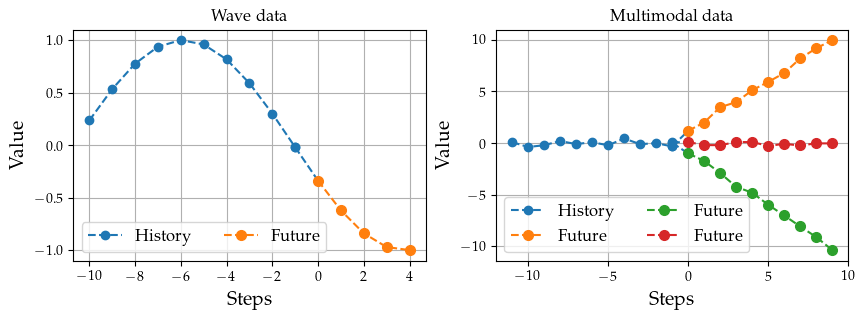

In [2]:
with open("data/hw1/wave_data_train.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]

index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
plt.plot([-1,0], [history[index][-1], future[index][0]], marker='o', linestyle='--', color="C0")
plt.plot(ts_future, future[index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Wave data")
plt.grid(True)
# plt.show()



with open("data/hw1/multimodal_data_test.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]


index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.subplot(1,2,2)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
for i in range(3):
    plt.plot([-1,0], [history[i*100 + index][-1], future[i*100 + index][0]], marker='o', linestyle='--', color="C0")
    plt.plot(ts_future, future[i*100 + index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Multimodal data")
plt.grid(True)
plt.show()


## Regression with sinusoidal trajectories

In this problem, you will learn a regular MLP to regress on sinusoidal data

In [3]:
# feel free to poke around the data
train_data = hw1_helper.TrajectoryData("data/hw1/wave_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/wave_data_test")

history_length = 10
future_length = 5
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 10000 examples
Test set has 500 examples


### Simple MLP predictor

In [4]:
# Define a simple MLP model
class MLP(torch.nn.Module):
    def __init__(self, history_length, future_length, hidden_size=32):
        super(MLP, self).__init__()
        
        # TODO: construct MLP network
        # Simple MLP with 3 layers and tanh activation functions
        self.model = torch.nn.Sequential(torch.nn.Linear(history_length, hidden_size),
                                         torch.nn.Tanh(),
                                         torch.nn.Linear(hidden_size, hidden_size),
                                         torch.nn.Tanh(),
                                         torch.nn.Linear(hidden_size, future_length))
        #############################

    def forward(self, x):
        return self.model(x)



In [5]:
hidden_size = 8
history_length = 10
future_length = 5

model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 30
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [6]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)


Epoch [1/30], Step [0/313], Loss: 0.5947
Epoch [1/30], Step [20/313], Loss: 0.5107
Epoch [1/30], Step [40/313], Loss: 0.4038
Epoch [1/30], Step [60/313], Loss: 0.4824
Epoch [1/30], Step [80/313], Loss: 0.3315
Epoch [1/30], Step [100/313], Loss: 0.2929
Epoch [1/30], Step [120/313], Loss: 0.2247
Epoch [1/30], Step [140/313], Loss: 0.1931
Epoch [1/30], Step [160/313], Loss: 0.2128
Epoch [1/30], Step [180/313], Loss: 0.1444
Epoch [1/30], Step [200/313], Loss: 0.1298
Epoch [1/30], Step [220/313], Loss: 0.1136
Epoch [1/30], Step [240/313], Loss: 0.1134
Epoch [1/30], Step [260/313], Loss: 0.0963
Epoch [1/30], Step [280/313], Loss: 0.0906
Epoch [1/30], Step [300/313], Loss: 0.1149
Epoch 1 completed with average loss: 0.2344
Epoch [2/30], Step [0/313], Loss: 0.0535
Epoch [2/30], Step [20/313], Loss: 0.0591
Epoch [2/30], Step [40/313], Loss: 0.0790
Epoch [2/30], Step [60/313], Loss: 0.0494
Epoch [2/30], Step [80/313], Loss: 0.0704
Epoch [2/30], Step [100/313], Loss: 0.0507
Epoch [2/30], Step [12

In [7]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-11, 5]
ylims = [-2,2]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 0.0002


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

#### ^Fig. 1: MLP trajectory prediction

### Answers to 1.1 (Multilayer perceptron)
**1.1(a)** The basic MLP defined above has 3 linear layers (input, hidden, output) with $\mathrm{tanh}$ activation functions. The input dimension was the observed trajectory length, and the output dimension was the prediction length. The resulting test loss was 0.0002, showing the basic MLP was able to fit to the dataset (for a fixed prediction horizon of 5) very well. The plot above shows the trajectory prediction for different input waves. I chose my hyperparameters ($\mathrm{tanh}$, hidden size of 8, learning rate of 1E-3) because they seemed like ``reasonable'' parameters to start with. $\mathrm{tanh}$ is nice because it's smooth and bounded between -1 and 1, 8 hidden parameters should be more than enough to represent this kind of 1D trajectory problem, and a learning rate of 1E-3 feels not too big and not too small.
<br>
<br>
**1.1(b)** In this context, the MLP did quite well in predicting the future trajectory over 5 timesteps. This makes sense to me, since we're basically letting the MLP overfit to predict trajectories for only 5 timesteps, but this comes with the significant drawback that its input and output sequence lengths are fixed.

### Simple LSTM predictor

In [8]:
    
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        # HINT: Use Pytorch built-in functions for LSTM and Linear layers.
        # HINT: batch dimension is dim=0
        
        # TODO: Define encoder LSTM.
        self.encoder = torch.nn.LSTM(self.input_dim, hidden_size=self.hidden_dim, batch_first=True, num_layers=2)
        ############################
        
        # TODO: Define decoder LSTM
        self.decoder = torch.nn.LSTM(self.input_dim, self.hidden_dim, batch_first=True, num_layers=2)
        ############################

        
        #TODO: Define linear project from hidden_dim to output_dim
        self.projection = torch.nn.Linear(self.hidden_dim, self.output_dim)
        ############################

        
        


    def forward(self, x, t_max, y=None, prob=1.):
        """
        Forward pass of the LSTM model.
        x: The input sequence [batch_size, seq_len, input_dim]
        t_max: maximum time steps to unroll
        y: The target sequence for teacher forcing (optional, used if teacher forcing is applied) [batch_size, t_max, output_dim]
        prob: Probability to apply teacher forcing (0 to 1). 1 means 100% teacher forcing, 
        """
        
        # making sure x and y is the appropriate size.
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)
        if y is not None and len(y.shape) == 2:
            y = y.unsqueeze(-1)
        
        ys = torch.zeros(x.shape[0], t_max, self.output_dim) # collect outputs
        # TODO: Run input through encoder to get initial hidden state for decoder
        _, (hx, cx) = self.encoder(x)
        # hx, cx = hx[:, -1, :], cx[:, -1, :]
        ############################

        
        # TODO: initial state for decoder is last input state
        dx = x[:, -1, :].unsqueeze(1)
        ############################
        # TODO: unroll decoder
        # TODO: if eval or no teacher forcing, use prediction from previous step
        # TODO: if train and using teacher forcing, use prob to determine whether to use ground truth or previous prediction
        
        for t in range(t_max):
            teacher_forcing = torch.rand(1).item() < prob
            # if not teacher_forcing or y is None:
            dy, (hx, cx) = self.decoder(dx, (hx, cx))
            y_pred = self.projection(dy)
            ys[:, t, :] = y_pred.squeeze(-1)
            
            if not teacher_forcing or y is None:
                dx = y_pred
            else:
                dx = y[:, t, :].unsqueeze(1)
        
        # print(ys.shape)
        ys = ys.squeeze()
        ############################

        
        return ys # [batch_size, ts_max, output_dim]

In [9]:
hidden_size = 4
future_length = 5
input_size = 1
output_size = 1

model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
prob = 0.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


def prob_schedule(i):
    return 1 - jax.nn.sigmoid(20 * (i - 0.5)).item()



In [10]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    prob = prob_schedule((epoch + 1)/num_epochs)
    for batch_idx, (data, target) in enumerate(train_dataloader):
        target = torch.tensor(target, requires_grad=True)
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} \t prob: {prob}')

print("Training finished!")


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Epoch [1/10], Step [0/313], Loss: 0.4761


/tmp/ipykernel_646778/3975504918.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, requires_grad=True)


Epoch [1/10], Step [100/313], Loss: 0.4077
Epoch [1/10], Step [200/313], Loss: 0.2306
Epoch [1/10], Step [300/313], Loss: 0.1410
Epoch 1 completed with average loss: 0.3106 	 prob: 0.9996646498620976
Epoch [2/10], Step [0/313], Loss: 0.1195
Epoch [2/10], Step [100/313], Loss: 0.0441
Epoch [2/10], Step [200/313], Loss: 0.0214
Epoch [2/10], Step [300/313], Loss: 0.0189
Epoch 2 completed with average loss: 0.0362 	 prob: 0.9975273769814521
Epoch [3/10], Step [0/313], Loss: 0.0135
Epoch [3/10], Step [100/313], Loss: 0.0086
Epoch [3/10], Step [200/313], Loss: 0.0136
Epoch [3/10], Step [300/313], Loss: 0.0085
Epoch 3 completed with average loss: 0.0110 	 prob: 0.9820137899369001
Epoch [4/10], Step [0/313], Loss: 0.0088
Epoch [4/10], Step [100/313], Loss: 0.0082
Epoch [4/10], Step [200/313], Loss: 0.0109
Epoch [4/10], Step [300/313], Loss: 0.0055
Epoch 4 completed with average loss: 0.0070 	 prob: 0.8807970806956291
Epoch [5/10], Step [0/313], Loss: 0.0072
Epoch [5/10], Step [100/313], Loss: 

In [11]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# try with different prediction horizons
prediction_horizon = 20
prediction = model(history, prediction_horizon)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, prediction_horizon + 2]
ylims = [-5,5]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 0.0069


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

#### ^Fig. 2: LSTM trajectory prediction

### Answers to 1.2 (LSTM)
**1.2(a)** The LSTM prediction module has two LSTM networks: one for the encoder (which constructs a hidden initial state based on a sequence of observations) and one for the decoder (which predicts the future trajectory given the hidden initial state). Teacher forcing is used to help guide the training process. The test loss over a future prediction horizon of 5 is 0.0023 (so pretty good). As for hyperparameters, I used a layer size of 2 for the encoder and decoder since that improved training over having 1 layer, my learning rate was a moderate 1E-3, and the hidden size was 4, which should be a good enough size for this simple 1D domain.
<br>
<br>
**1.2(b)** One primary of using an RNN/LSTM for doing behavior prediction are mainly that it can encode/predict arbitrary sequence lengths, avoiding the retraining issue that comes with using something with a fixed input/output size like an MLP. On the other hand, LSTMs can suffer from capturing longer-term dependencies and thus may make more erroneous predictions.  
<br>
<br>
**1.2(c)** When the trajectory is rolled out for a much longer horizon than what the network was trained on (eg. a horizon of 20), its prediction becomes much more poor as time goes on (the above plot shows this for the predicted green sequence that goes beyong the orange ground-truth future).

## Regression on multimodal data

Now we repeat the same steps but with data where the future has multimodal outcome. 

In [12]:
# load multimodal data
train_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_test")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Simple MLP predictor (multimodal data)

In [13]:

hidden_size = 32
# You should be able to use your MLP class
model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [14]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)

Epoch [1/10], Step [0/469], Loss: 21.6570
Epoch [1/10], Step [20/469], Loss: 26.3104
Epoch [1/10], Step [40/469], Loss: 15.6339
Epoch [1/10], Step [60/469], Loss: 26.3989
Epoch [1/10], Step [80/469], Loss: 23.0976
Epoch [1/10], Step [100/469], Loss: 26.6754
Epoch [1/10], Step [120/469], Loss: 27.6218
Epoch [1/10], Step [140/469], Loss: 28.7718
Epoch [1/10], Step [160/469], Loss: 25.4677
Epoch [1/10], Step [180/469], Loss: 31.3526
Epoch [1/10], Step [200/469], Loss: 28.8713
Epoch [1/10], Step [220/469], Loss: 28.9495
Epoch [1/10], Step [240/469], Loss: 25.3137
Epoch [1/10], Step [260/469], Loss: 26.7241
Epoch [1/10], Step [280/469], Loss: 26.5177
Epoch [1/10], Step [300/469], Loss: 21.5719
Epoch [1/10], Step [320/469], Loss: 24.1096
Epoch [1/10], Step [340/469], Loss: 26.5392
Epoch [1/10], Step [360/469], Loss: 25.4710
Epoch [1/10], Step [380/469], Loss: 22.8052
Epoch [1/10], Step [400/469], Loss: 21.6086
Epoch [1/10], Step [420/469], Loss: 28.5736
Epoch [1/10], Step [440/469], Loss: 26

In [15]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 25.8262


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

#### ^Fig. 3: MLP prediction on multimodal trajectory data

### Simple LSTM predictor (multimodal data)

In [16]:
hidden_size = 4
# You should be able to use your LSTM class
model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


In [17]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/469], Loss: 25.4558
Epoch [1/10], Step [100/469], Loss: 25.2427
Epoch [1/10], Step [200/469], Loss: 26.5217
Epoch [1/10], Step [300/469], Loss: 22.9163
Epoch [1/10], Step [400/469], Loss: 21.6573
Epoch 1 completed with average loss: 25.7045
Epoch [2/10], Step [0/469], Loss: 21.7018
Epoch [2/10], Step [100/469], Loss: 29.9890
Epoch [2/10], Step [200/469], Loss: 24.0406
Epoch [2/10], Step [300/469], Loss: 27.5475
Epoch [2/10], Step [400/469], Loss: 25.1631
Epoch 2 completed with average loss: 25.7057
Epoch [3/10], Step [0/469], Loss: 25.3174
Epoch [3/10], Step [100/469], Loss: 31.2286
Epoch [3/10], Step [200/469], Loss: 25.3742
Epoch [3/10], Step [300/469], Loss: 30.0591
Epoch [3/10], Step [400/469], Loss: 26.4489
Epoch 3 completed with average loss: 25.7044
Epoch [4/10], Step [0/469], Loss: 26.5802
Epoch [4/10], Step [100/469], Loss: 24.2069
Epoch [4/10], Step [200/469], Loss: 27.7567
Epoch [4/10], Step [300/469], Loss: 28.8814
Epoch [4/10], Step [400/469], Loss: 2

In [18]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# TODO: try with different prediction horizons
prediction_horizon = future_length
prediction = model(history, prediction_horizon)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')

xlims = [-11, prediction_horizon + 2]
ylims = [-12, 12]

interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 25.7152


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

#### ^Fig. 4: LSTM prediction on multimodal trajectory data

### Answers to 2 (multimodal regression with the MLP and LSTM)
**2(a)** From Figs. 3 and 4, we can see the plots for the respective MLP and LSTM predictions over the multimodal trajectory data. Their losses were much higher (~25 for both models) than for the unimodal trajectory case.
<br>
<br>
**2(b)** They are bad at performing multimodal prediction, and seem to just estimate the mean of all possible trajectories (which is the middle path). This makes sense to me though, because since there are three distinct modes and the loss basically incentivizes the networks to converge to the single middle mode (through MSE training) and there is no explicitly probabilistic modelling occuring.

## Consider CVAEs

First, define the encoder and decoder. We will consider some simple MLP encoders. Generally, for trajectory data, it's typically more common to use RNNs or transformers, but since we are considering a small toy problem, we just consider MLP for now since it's simpler.


In [19]:

# some simple MLP encoders. For trajectory data, it's typically more common to use RNNs or transformers
class MLPEncoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # TODO: Construct an MLP encoder
        self.model = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim),
                                         torch.nn.Tanh(),
                                         torch.nn.Linear(hidden_dim, hidden_dim),
                                         torch.nn.Tanh(),
                                         torch.nn.Linear(hidden_dim, output_dim))
        ############################


    def forward(self, x):
        return self.model(x)
    
    
class MLPDecoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPDecoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # TODO: Construct an MLP decoder
        self.model = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim),
                                         torch.nn.Tanh(),
                                         torch.nn.Linear(hidden_dim, hidden_dim),
                                         torch.nn.Tanh(),
                                         torch.nn.Linear(hidden_dim, output_dim))
        ############################


    def forward(self, x):
        return self.model(x)


# Some helper functions
def repeat_n(ten, n):
    return torch.stack([ten] * n, dim=0)

def beta_schedule(i):
    return jax.nn.sigmoid(20 * (i - 0.5)).item()


In [20]:
train_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_test")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Continuous CVAE

In [ ]:
class ContinuousCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior        
        '''
        
        super(ContinuousCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        
        # TODO: Linear layers to project encoder/decoder to mean and logvar
        self.mean_projection_encoder = torch.nn.Linear(self.importance.output_dim, self.latent_dim)
        self.logvar_projection_encoder = torch.nn.Linear(self.importance.output_dim, self.latent_dim)
        self.mean_projection_decoder = torch.nn.Linear(self.decoder.output_dim, self.decoder.output_dim)
        self.logvar_projection_decoder = torch.nn.Linear(self.decoder.output_dim, self.decoder.output_dim)
        ############################

        
    def encode_importance(self, x, y):
        '''Computes mean and log(covariance) of q(z|x,y), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of q(z|x,y)
        xy = torch.cat([x, y], dim=-1)
        hx = self.importance(xy)
        z_mu = self.mean_projection_encoder(hx)
        z_logvar = self.logvar_projection_encoder(hx)
        ############################
        
        return z_mu, z_logvar
    
    
    def encode_prior(self, x):
        '''Computes mean and log(covariance) of p(z|x), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of p(z|x)
        hx = self.prior(x)
        z_mu = self.mean_projection_encoder(hx)
        z_logvar = self.logvar_projection_encoder(hx)
        ############################
        
        return z_mu, z_logvar
    
    
    def reparameterize(self, mu, logvar, n=1):
        '''samples from a normal distributions parameterized by mu and logvar. Uses PyTorch built-in reparameratization trick'''
        
        prob = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(torch.exp(logvar)))
        
        return prob.rsample((n,))
    
    
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        
        # TODO: compute y_mu and y_logvar of p(y|x,z)
        xz = torch.cat([x, z], dim=-1)
        hy = self.decoder(xz)
        y_mu = self.mean_projection_decoder(hy)
        y_logvar = self.logvar_projection_decoder(hy)
        ############################
        
        return y_mu, y_logvar

    
    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        
        #  get p(z|x,(y))
        if self.training:
            z_mu, z_logvar = self.encode_importance(x, y)
        else:
            z_mu, z_logvar = self.encode_prior(x)
        # sample from p(z|x,(y)) n times
        z = self.reparameterize(z_mu, z_logvar, n)
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z)     
           
        return z_mu, z_logvar, y_mu, y_logvar
    

    # need to reparameterize again with a CVAE compared to a standard VAE where the decoder reconstructs y directly
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        
        _, _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return self.reparameterize(y_mu, y_logvar, num_samples)

    
    
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with continuous latent space. Optional: beta term that weigh kl divergence term'''
        
        q_mu, q_logvar, y_mu, y_logvar = self(x, y, z_samples) # get parameters for q(z|x,y) and p(y|x,z) where z~q(z|x,y)
        p_mu, p_logvar = self.encode_prior(x) # get parameters for p(z|x)
        
        # construct the distributions
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        q = torch.distributions.MultivariateNormal(loc=q_mu, covariance_matrix=torch.diag_embed(torch.exp(q_logvar)))  # q(z|x,y)
        p = torch.distributions.MultivariateNormal(loc=p_mu, covariance_matrix=torch.diag_embed(torch.exp(p_logvar)))  # p(z|x)
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean() # log likelihood of data 
        kl_div = torch.distributions.kl.kl_divergence(q, p).mean()  # q_z * (log(q_z) - log(p_z))
        
        return loglikelihood + beta * kl_div
        


      

In [22]:
# continuous cvae
# network parameters
latent_dim = 1 # size of latent space
history_length = 11
future_length = 10
hidden_dim = 8
enc_dim = 8
dec_dim = 8

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim+history_length, future_length, dec_dim)

cvae = ContinuousCVAE(latent_dim, encoder, decoder, prior)

num_epochs = 10
learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)


batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)



In [23]:
# train model
z_samples = 16
cvae.train()

for epoch in range(num_epochs):
    running_loss = 0
    beta = beta_schedule((epoch + 1)/ num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
    for batch_idx, (history, future) in enumerate(train_dataloader):
        q_mu, q_logvar, y_mu, y_logvar = cvae(history, future)
        p_mu, p_logvar = cvae.encode_prior(history)
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, z_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

Epoch [1/10], Step [0/1875], Loss: 177.1839
Epoch [1/10], Step [100/1875], Loss: 55.9266
Epoch [1/10], Step [200/1875], Loss: 28.2359
Epoch [1/10], Step [300/1875], Loss: 25.0770
Epoch [1/10], Step [400/1875], Loss: 28.8982
Epoch [1/10], Step [500/1875], Loss: 26.0676
Epoch [1/10], Step [600/1875], Loss: 27.7806
Epoch [1/10], Step [700/1875], Loss: 25.9237
Epoch [1/10], Step [800/1875], Loss: 28.0135
Epoch [1/10], Step [900/1875], Loss: 22.2817
Epoch [1/10], Step [1000/1875], Loss: 15.7669
Epoch [1/10], Step [1100/1875], Loss: 25.8554
Epoch [1/10], Step [1200/1875], Loss: 18.7114
Epoch [1/10], Step [1300/1875], Loss: 22.5337
Epoch [1/10], Step [1400/1875], Loss: 21.6362
Epoch [1/10], Step [1500/1875], Loss: 25.5267
Epoch [1/10], Step [1600/1875], Loss: 29.4213
Epoch [1/10], Step [1700/1875], Loss: 21.3411
Epoch [1/10], Step [1800/1875], Loss: 22.7148
======= Epoch 1 completed with average loss: 27.8544 =======
Epoch [2/10], Step [0/1875], Loss: 25.2798
Epoch [2/10], Step [100/1875], Lo

In [24]:
# Visualize prediction on test data

cvae.eval()

num_samples = 8
num_latent_samples = 8

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_generative(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

#### ^Fig. 5: Training a CVAE for predicting over multimodal trajectory data

### Answers to 2.1 (Continuous latent space CVAE)
**2.1(a)** See the code above for the finished continuous latent space CVAE implementation
<br>
<br>
**2.1(b)** From Fig. 5 above, we can see that the CVAE does a much better job of learning over multimodal data. However, one thing I noticed was that the results can be very different between different training runs. In the above case, it seemed to learn the trajectories quite well, but in other training runs it has way more variance in the predictions. My hypothesis is that this is due to the weight initializing performed by pytorch by default.

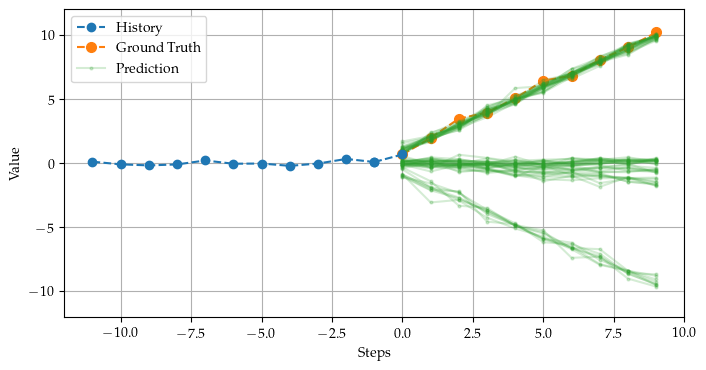

In [25]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)


### Discrete CVAE

In [26]:
class DiscreteCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior, num_categories):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior  
        num_categories: number of categories per latent dimension 
        '''
        
        super(DiscreteCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        
        self.logits_projection_encoder = torch.nn.Linear(importance.output_dim, latent_dim * num_categories)
        self.mean_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.logvar_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.num_categories = num_categories
        
        # Gumbel-softmax reparameterization
        self.gumbel_temperature = 0.1
        
    def encode_importance(self, x, y):
        '''Computes logits of q(z|x,y), assumes one-hot categorical'''
        xy = torch.cat([x, y], dim=-1)
        h = self.importance(xy)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)      
        return z_logits
    
    
    def encode_prior(self, x):
        '''Computes logits of p(z|x), assumes one-hot categorical'''
        h = self.prior(x)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)
        
        return z_logits


    def reparameterize(self, logits):
        '''Sample latent variables using one-hot categorical distributions. Uses gumbel-softmax trick. Pytorch has a bulit-in function for this.'''
        
        return F.gumbel_softmax(logits, tau=self.gumbel_temperature, hard=True) 
        
        
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        xz = torch.cat([x, z], dim=-1)
        g = self.decoder(xz)
        y_mu = self.mean_projection_decoder(g)
        y_logvar = torch.clip(self.logvar_projection_decoder(g), min=-10, max=1)
        
        return y_mu, y_logvar


    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        #  get p(z|x,(y)) and samples from it n times
        if self.training:
            logits = self.encode_importance(x, y) # [bs, latent_dim, num_categories]
            z = self.reparameterize(repeat_n(logits, n)) # [n, bs, latent_dim, num_categories]
        else:
            logits = self.encode_prior(x) # [bs, latent_dim, num_categories]
            z = torch.distributions.OneHotCategorical(logits=logits).sample((n,)) # [n, bs, latent_dim, num_categories]
        z_flatten = z.view(n, -1, self.latent_dim * self.num_categories)  # reshapes to [n, bs, latent_dim * num_categories]
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z_flatten) 

        return logits, y_mu, y_logvar
    
    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return  torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar))).rsample((num_samples,))
        
        
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with discrete latent space. Optional: beta term that weigh kl divergence term'''

        logits, y_mu, y_logvar = self.forward(x, y, z_samples)
        prior_logits = cvae.encode_prior(x)
        
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        
        q_z = F.softmax(logits, dim=-1)  # q(z|x,y)
        log_p_z = F.log_softmax(prior_logits, dim=-1)  # log(p(z|x))
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean()
        kl_div = torch.nn.KLDivLoss(reduction="batchmean")(log_p_z, q_z)
        
        return loglikelihood + beta * kl_div
      

        


In [27]:
# discrete CVAE

history_length = 11
future_length = 10
hidden_dim = 8
enc_dim = 8
dec_dim = 8

latent_dim = 2
num_categories = 3

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim * num_categories + history_length, future_length, dec_dim)

cvae = DiscreteCVAE(latent_dim, encoder, decoder, prior, num_categories)

learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate, weight_decay=1E-2)

batch_size = 8
num_epochs = 10
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [28]:
# train model
cvae.train()
num_latent_samples = 8
for epoch in range(num_epochs):
    running_loss = 0
    for batch_idx, (history, future) in enumerate(train_dataloader):
        beta = beta_schedule((epoch+1) / num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, num_latent_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

Epoch [1/10], Step [0/1875], Loss: 103.7589
Epoch [1/10], Step [100/1875], Loss: 32.3026
Epoch [1/10], Step [200/1875], Loss: 58.4617
Epoch [1/10], Step [300/1875], Loss: 49.0496
Epoch [1/10], Step [400/1875], Loss: 55.3160
Epoch [1/10], Step [500/1875], Loss: 49.4648
Epoch [1/10], Step [600/1875], Loss: 29.0333
Epoch [1/10], Step [700/1875], Loss: 15.5318
Epoch [1/10], Step [800/1875], Loss: 11.9655
Epoch [1/10], Step [900/1875], Loss: 9.9612
Epoch [1/10], Step [1000/1875], Loss: 10.3373
Epoch [1/10], Step [1100/1875], Loss: 8.0179
Epoch [1/10], Step [1200/1875], Loss: 9.7872
Epoch [1/10], Step [1300/1875], Loss: 8.1791
Epoch [1/10], Step [1400/1875], Loss: 7.3301
Epoch [1/10], Step [1500/1875], Loss: 7.4557
Epoch [1/10], Step [1600/1875], Loss: 9.0422
Epoch [1/10], Step [1700/1875], Loss: 6.6142
Epoch [1/10], Step [1800/1875], Loss: 8.1395
======= Epoch 1 completed with average loss: 26.4528 =======
Epoch [2/10], Step [0/1875], Loss: 8.1194
Epoch [2/10], Step [100/1875], Loss: 6.6449

In [29]:
# Visualize prediction on test data

cvae.eval()
num_latent_samples = 32
num_samples = 1

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_generative(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

#### ^Fig. 6: Predictions from VAE with discrete latent space

### Answers to 2.2 (CVAE with discrete latent space)
**2.2(a)** The shape of the default/given latent vector is 2. With $c=3$ categories and a dimension $n=2$, the number of possible values for the latent vector is $c^n = 3^2=9$ and the shape would be $n \cdot c = 3 \cdot 2 = 6$ for the given discrete CVAE class. An example of an (unflattened) latent $n \times c$ one-hot latent vector would be: $\,\, z = \begin{bmatrix}1 & 0 & 1 \\ 0 & 0 & 1\end{bmatrix},\,$ where the top row is the first one-hot category and the bottom row is the second one-hot category.
<br>
<br>
**2.2(b)** The discrete CVAE also does quite well in modelling multimodal trajectories in this context. In addition to traininng with a latent dim of $n \cdot c = 2 \cdot 3$, I also tried $1 \cdot 4$, $3 \cdot 2$, and $3 \cdot 3$. I found that the performance when the latent dimension was $1 \cdot 4$ (one row, 4 categories) was worse than that of the other three configurations, which were all roughly similar. 
<br>
<br>
**2.2(c)** Comparing the results between the CVAE with the continuous latent space versus the discrete latent space, I observed that the model with a continuous latent space (if it trained well) would have less possible modes than the model with a discrete latent space, thus representing the data better. On the other hand, it seemed like the continuous latent space model across training runs suffered more from poorly initialized weights (i.e., it would have many more predicted modes) than the discrete CVAE, so it had more variance in performance. I suspect this is because with the discrete latent space in this problem, there are a very small number of trajectory modes that can be represented in latent space, thus leading to more consistent outputs across training runs.

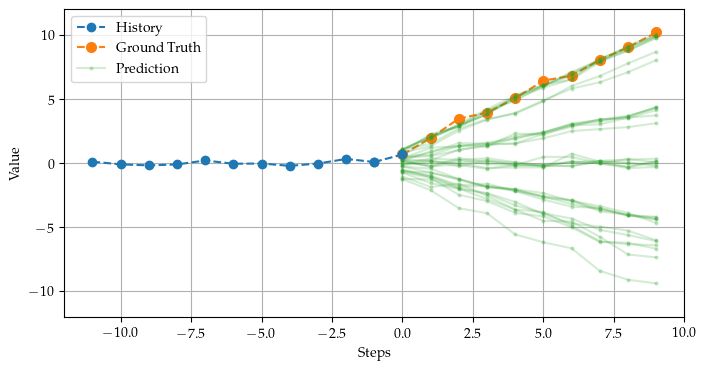

In [30]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)
